In [55]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pathlib
import os
import json
import sys
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data as data
import numpy as np
import pickle
import collections
import pandas as pd
# imports for graphs
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

In [39]:
# network 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1 * 1024, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fcOut = nn.Linear(32, 1)
        # define layernorm
        self.ln1 = nn.LayerNorm(1024)
        #self.ln2 = nn.LayerNorm(256)
        self.ln3 = nn.LayerNorm(128)
        self.ln4 = nn.LayerNorm(32)
        # self.sigmoid = nn.Sigmoid()
        #self.tanh = nn.Tanh()

    def forward_once(self, input):
        #print(input)
        #print(input.shape)
        x = self.ln1(input)
        x = F.relu(self.fc1(x))
        # x = self.ln2(x)
        x = self.dropout1(F.relu(self.fc2(x)))
        #x = F.relu(self.fc2(x))
        x = self.ln3(x)
        x = F.relu(self.fc3(x))
        x = self.ln4(x)
        # x = F.tanh(self.fcOut(x))
        x = self.fcOut(x)
        return x

    def forward(self, input1, input2, input3):
        # output1 = anchor, output2 = pos, output3 = neg

        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

In [40]:
# define file paths

home_dir = pathlib.Path.home().joinpath('PycharmProjects', 'triplet_net')
embedding_path = pathlib.Path.joinpath(home_dir, 'dataset', 'embeddings', 'per_prot_emb_full.p')
model_name = 'triplet_net_96_0.8'
with open(embedding_path, 'rb') as fp:
    embeddings = pickle.load(fp)

In [41]:
# define Dataset class
class Dataset(data.Dataset):
    # characterizes a dataset for PyTorch
    def __init__(self, list_IDs, triplets, embeddings):
        self.list_IDs = list_IDs
        self.triplets = triplets
        self.embeddings = embeddings

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        # generates one sample of data
        # select sample
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        ID = self.list_IDs[index]
        # get embedding of anchor protein
        x1 = self.triplets[ID][0]
        x1_t = torch.Tensor(self.embeddings[x1])
        x1_t = x1_t.to(device)
        # get embedding of positive protein
        x2 = self.triplets[ID][1]
        x2_t = torch.Tensor(self.embeddings[x2])
        x2_t = x2_t.to(device)
        # get embedding of negative protein
        x3 = self.triplets[ID][2]
        x3_t = torch.Tensor(self.embeddings[x3])
        x3_t = x3_t.to(device)
        # print(x1_t.is_cuda)

        return x1_t, x2_t, x3_t, x1, x2, x3

In [42]:
# load model from checkpoint
def load_checkpoint(model, optimizer):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    return val_loss

In [43]:
# parameters
params = {'batch_size': 1,
         'shuffle': False,
         'num_workers': 0}

test_data = pathlib.Path.joinpath(home_dir, 'dataset', 'test', 'test_triplets.json')
#test_l = pathlib.Path.joinpath(home_dir, 'dataset', 'test', 'full_test_label.json')

with open(test_data, 'r') as fp:
    test_pairs = json.load(fp)
    
list_IDs_test = list(test_pairs.keys())

# Generators
test_set = Dataset(list_IDs_test, test_pairs, embeddings)
test_loader = torch.utils.data.DataLoader(test_set, **params)

In [44]:
#creating the original network and couting the paramenters of different networks
PATH = pathlib.Path.joinpath(home_dir, 'trained_models')
model_path = pathlib.Path.joinpath(PATH, model_name + '.pt')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
model = Net()
optimizer = optim.Adam(model.parameters(), lr = 0.0006)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict['model_state_dict'])
model.to(device)
model.eval()

cuda:0
1.5.0


Net(
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fcOut): Linear(in_features=32, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (ln4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
)

In [45]:
def test_eval(model, test_loader, model_name):
    result_df = pd.DataFrame(columns=['anchor', 'positive', 'negative', 'dist_pos', 'dist_neg', 'valid_triplet'])
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    dist_pos = []
    dist_neg = []
    anchor = []
    positive = []
    negative = []
    valid_triplet = []
    for i, data in enumerate(test_loader,0):
        x0, x1, x2, pA, pB, pC = data
        anchor.append(pA[0])
        positive.append(pB[0])
        negative.append(pC[0])
        # perform inference
        output1, output2, output3 = model(x0.to(device), x1.to(device), x2.to(device))
        # calculate L2 distance
        distance_positive = (output1 - output2).pow(2).sum(1)  # .pow(.5)
        distance_negative = (output1 - output3).pow(2).sum(1)
        dist_pos.append(distance_positive.cpu().data.numpy()[0])
        dist_neg.append(distance_negative.cpu().data.numpy()[0])
        if distance_positive < distance_negative:
            valid_triplet.append(1)
        else:
            valid_triplet.append(0)
        
    # populate dataframe
    result_df['anchor'], result_df['positive'], result_df['negative'] = anchor, positive, negative
    result_df['dist_pos'], result_df['dist_neg'] = dist_pos, dist_neg
    result_df['valid_triplet'] = valid_triplet
        
    return result_df

In [46]:
result_df = test_eval(model, test_loader, model_name)

In [47]:
result_df

,anchor,positive,negative,dist_pos,dist_neg,valid_triplet
0,Q5SYE7,O41932,Q8TF72,3.496549e-02,0.134187,1
1,P53667,Q02297,P41279,9.213673e-03,0.001455,0
2,Q9Y561,Q9NPI5,P21860,4.883185e-04,0.000038,0
3,P88997,Q9GZU2,P06789,3.013847e-04,0.007985,1
4,Q9P299,Q9Y678,Q9Y296,6.174176e-03,0.014845,1
...,...,...,...,...,...,...
104,Q96PM5,P09669,Q96EQ8,4.763443e-04,0.000066,0
105,O94829,Q9Y5S9,Q9Y5L0,4.691723e-01,0.000030,0
106,Q8TAQ2,Q81XH4,O75553,5.980002e-04,0.000628,1
107,Q7Z6I6,Q81ZE7,Q12774,4.068042e-03,0.001097,0


In [48]:
# save predictions
path = pathlib.Path.cwd().joinpath('predictions', 'triplets', model_name + '.csv')
result_df.to_csv(path, index=False)

In [54]:
len(result_df.loc[result_df['valid_triplet']==1])

56

<h1>Precision-Recall Curves</h1>

In [102]:
path = pathlib.Path.home().joinpath('Documents', 'ms_thesis_ppi')
graph_file = pathlib.Path.joinpath(path, 'one_shot_demo', 'predictions', 'triplets', 'graphs')
pred_file = 'triplet_net_64_0.8_180'
pred_path = pathlib.Path.joinpath(path, 'one_shot_demo', 'predictions','triplets', pred_file + '.csv')

In [103]:
df = pd.read_csv(pred_path)
df

,anchor,positive,negative,dist_pos,dist_neg,valid_triplet
0,Q5SYE7,O41932,Q8TF72,1.098130,0.000812,0
1,P53667,Q02297,P41279,0.047014,0.000174,0
2,Q9Y561,Q9NPI5,P21860,0.074965,0.036655,0
3,P88997,Q9GZU2,P06789,0.000584,0.000002,0
4,Q9P299,Q9Y678,Q9Y296,0.021795,0.000467,0
...,...,...,...,...,...,...
104,Q96PM5,P09669,Q96EQ8,0.216323,0.082478,0
105,O94829,Q9Y5S9,Q9Y5L0,0.020754,0.015085,0
106,Q8TAQ2,Q81XH4,O75553,0.000004,0.008423,1
107,Q7Z6I6,Q81ZE7,Q12774,0.003214,0.003895,1


In [104]:
sortdf = df.sort_values(by=['dist_pos'])
print(sortdf)
target = list(sortdf['valid_triplet'])
# pred = list(sortdf['predicted'])
# dist = list(sortdf['distance'])
cumsum = np.cumsum(target)
rank = np.arange(len(cumsum)) + 1
Num = cumsum[-1]
prec = cumsum / rank
rec = cumsum / Num
print(prec)
print(rec)

     anchor positive negative      dist_pos  dist_neg  valid_triplet
28   Q7Z4K8   Q96EQ8   O75161  2.386878e-08  0.060290              1
106  Q8TAQ2   Q81XH4   O75553  4.301737e-06  0.008423              1
32   Q9NWR8   Q5NE99   P46736  2.072402e-05  0.001030              1
37   Q9UHB4   Q9BT92   Q86XR2  3.572922e-05  0.239489              1
79   Q8IZH2   P48643   Q9NQC7  5.005326e-05  1.209548              1
..      ...      ...      ...           ...       ...            ...
58   Q9NQW6   Q8NA82   Q96L73  1.051449e+00  1.140483              1
0    Q5SYE7   O41932   Q8TF72  1.098130e+00  0.000812              0
77   Q8TF72   P0CK53   Q5SYE7  1.130121e+00  0.000812              0
99   Q12824   P06789   Q49AR2  1.150625e+00  0.980227              0
50   Q9H0A9   A1L4K1   Q2KHM9  1.290501e+00  1.237749              0

[109 rows x 6 columns]
[1.         1.         1.         1.         1.         1.
 1.         0.875      0.88888889 0.8        0.72727273 0.75
 0.76923077 0.78571429 0.8  

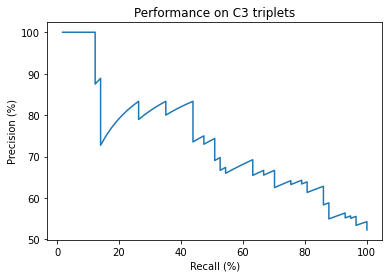

In [105]:
mrec = np.concatenate(([0.], rec, [1.]))
mpre = np.concatenate(([0.], prec, [0.]))
p_rec = [i * 100 for i in rec]
p_prec = [i * 100 for i in prec]
plt.plot(p_rec, p_prec)
plt.xlabel('Recall (%)')
plt.ylabel('Precision (%)')
plt.title('Performance on C3 triplets')
sav_img = pathlib.Path.joinpath(graph_file, pred_file + '.jpg')
plt.savefig(sav_img)
plt.show()

In [106]:
y_score = []
for i in range(len(target)):
    y_score.append(1)
y_test = target    
average_precision = average_precision_score(y_test, y_score)
print(average_precision)

0.5229357798165137


In [107]:
df.sort_values(by=['dist_pos'], ascending=True).head(10)

,anchor,positive,negative,dist_pos,dist_neg,valid_triplet
28,Q7Z4K8,Q96EQ8,O75161,2.386878e-08,0.060290,1
106,Q8TAQ2,Q81XH4,O75553,4.301737e-06,0.008423,1
32,Q9NWR8,Q5NE99,P46736,2.072402e-05,0.001030,1
37,Q9UHB4,Q9BT92,Q86XR2,3.572922e-05,0.239489,1
79,Q8IZH2,P48643,Q9NQC7,5.005326e-05,1.209548,1
23,Q8D1H5,P15529,O14744,1.024585e-04,0.121255,1
89,Q9SJF3,Q92636,O75553,1.924282e-04,0.023934,1
19,Q13415,Q13416,Q2KHM9,3.778300e-04,0.000170,0
44,P35398,P51843,P41235,5.817070e-04,0.010850,1
3,P88997,Q9GZU2,P06789,5.835802e-04,0.000002,0


[[ 0 52]
 [ 0 57]]


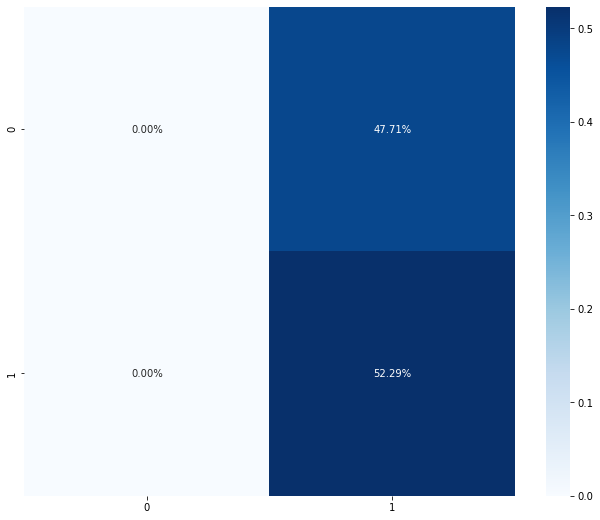

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
cf_matrix = confusion_matrix(target, y_score)
print(cf_matrix)
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()